# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [350]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [351]:
def get_stock_data(ticker, start_date, end_date):
    
    data_dir = "StockData" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def load_from_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            df = df.loc[start_date:end_date]
            return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def download_from_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = load_from_csv()
    
    if data is None or data.empty:
        data = download_from_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [352]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

tickers_settore1 = ['AAPL', 'INTC'] # Apple e Intel
tickers_settore2 = ['AMZN', 'WMT'] # Amazon e Walmart
tickers_settore3 = ['V', 'MA'] # Visa e Mastercard

tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

for ticker in tickers:
    df = get_stock_data(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.859398   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.140236   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.370214   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.450140   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.393904   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In [353]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.859398,20.772066,15.442000,20.799509,49.775650,72.443565
2014-06-03,20.140236,21.076870,15.359500,20.785961,49.262760,71.785408
2014-06-04,20.370214,21.031145,15.339000,20.899773,49.288418,71.757202
2014-06-05,20.450140,21.076870,16.178499,20.951252,49.472580,72.246124
2014-06-06,20.393904,21.465481,16.483500,20.921448,49.654419,72.838463
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


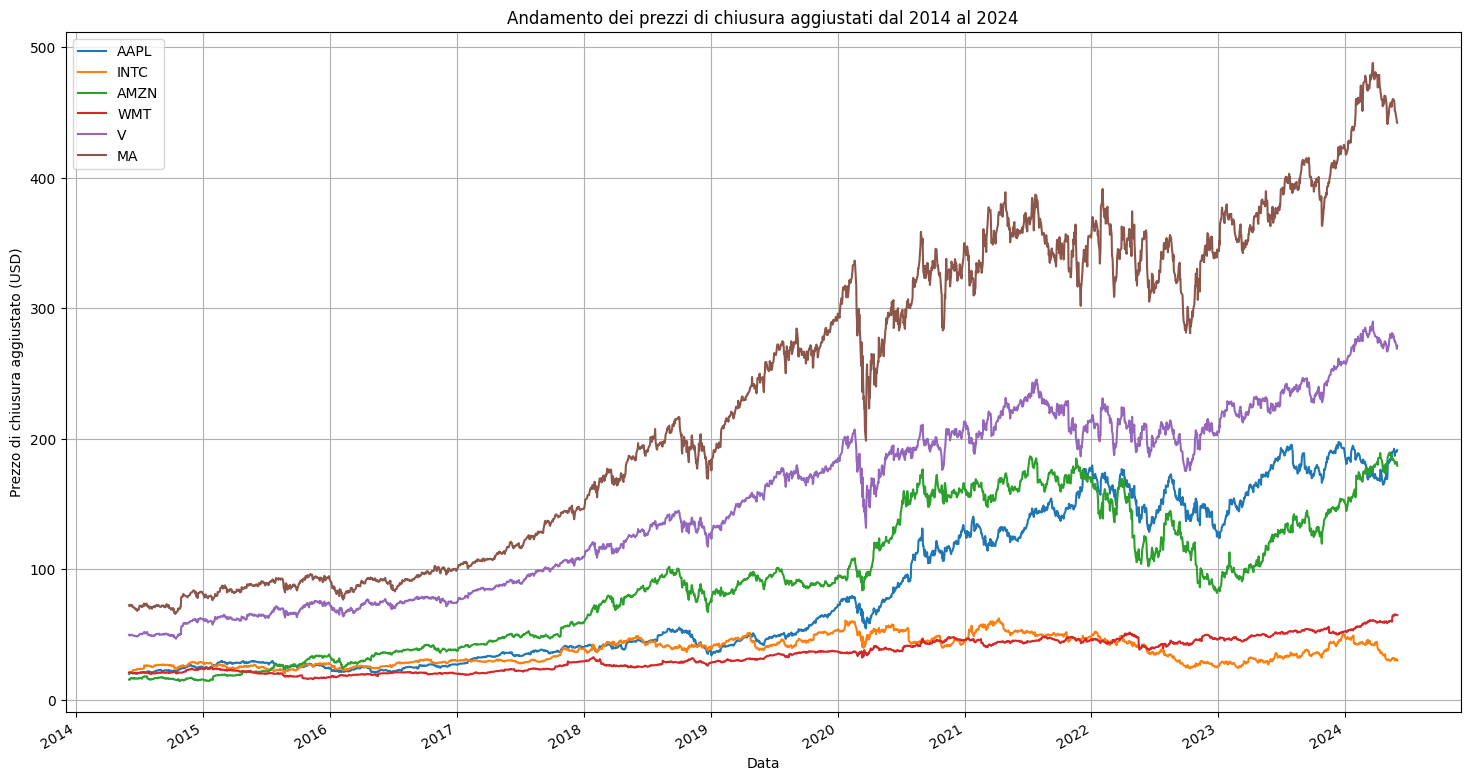

In [354]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [355]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
color_map = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=color_map(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [356]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014141,0.014674,-0.005343,-0.000651,-0.010304,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000521,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003736,0.006814
2014-06-06,-0.002750,0.018438,0.018852,-0.001423,0.003676,0.008199
2014-06-09,0.016001,-0.009230,-0.006582,-0.002590,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


In [357]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999349,0.989696,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000521,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003736,1.006814
2014-06-06,0.997250,1.018438,1.018852,0.998577,1.003676,1.008199
2014-06-09,1.016001,0.990770,0.993418,0.997410,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


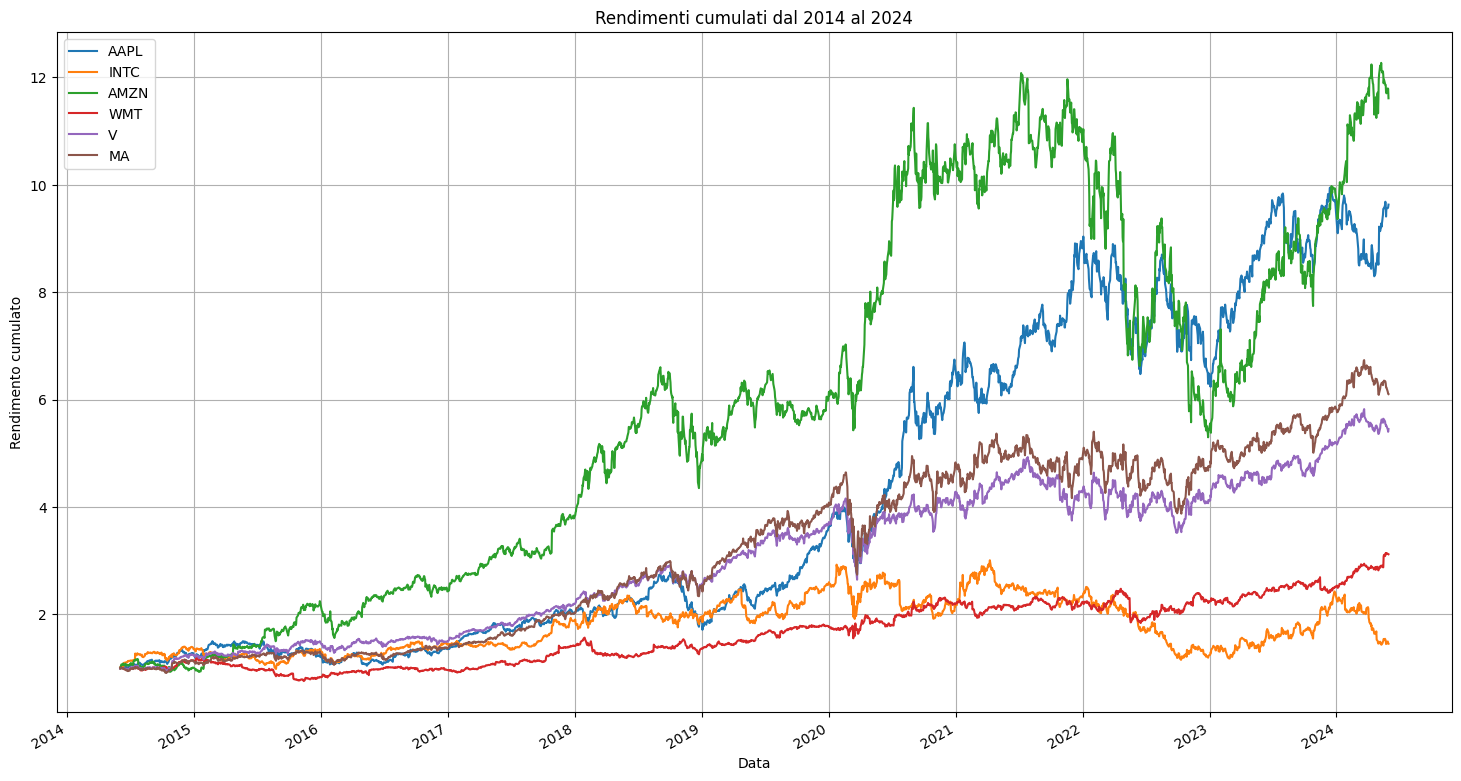

In [358]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [359]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1/numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253984
INTC    0.038066
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

In [360]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # i rendimenti lordi li ho calcolati in precedenza
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000652,-0.010357,-0.009127
2014-06-04,0.011354,-0.002172,-0.001336,0.005460,0.000521,-0.000393
2014-06-05,0.003916,0.002172,0.053285,0.002460,0.003729,0.006790
2014-06-06,-0.002754,0.018270,0.018677,-0.001424,0.003669,0.008165
2014-06-09,0.015875,-0.009273,-0.006604,-0.002594,-0.001974,-0.007905
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


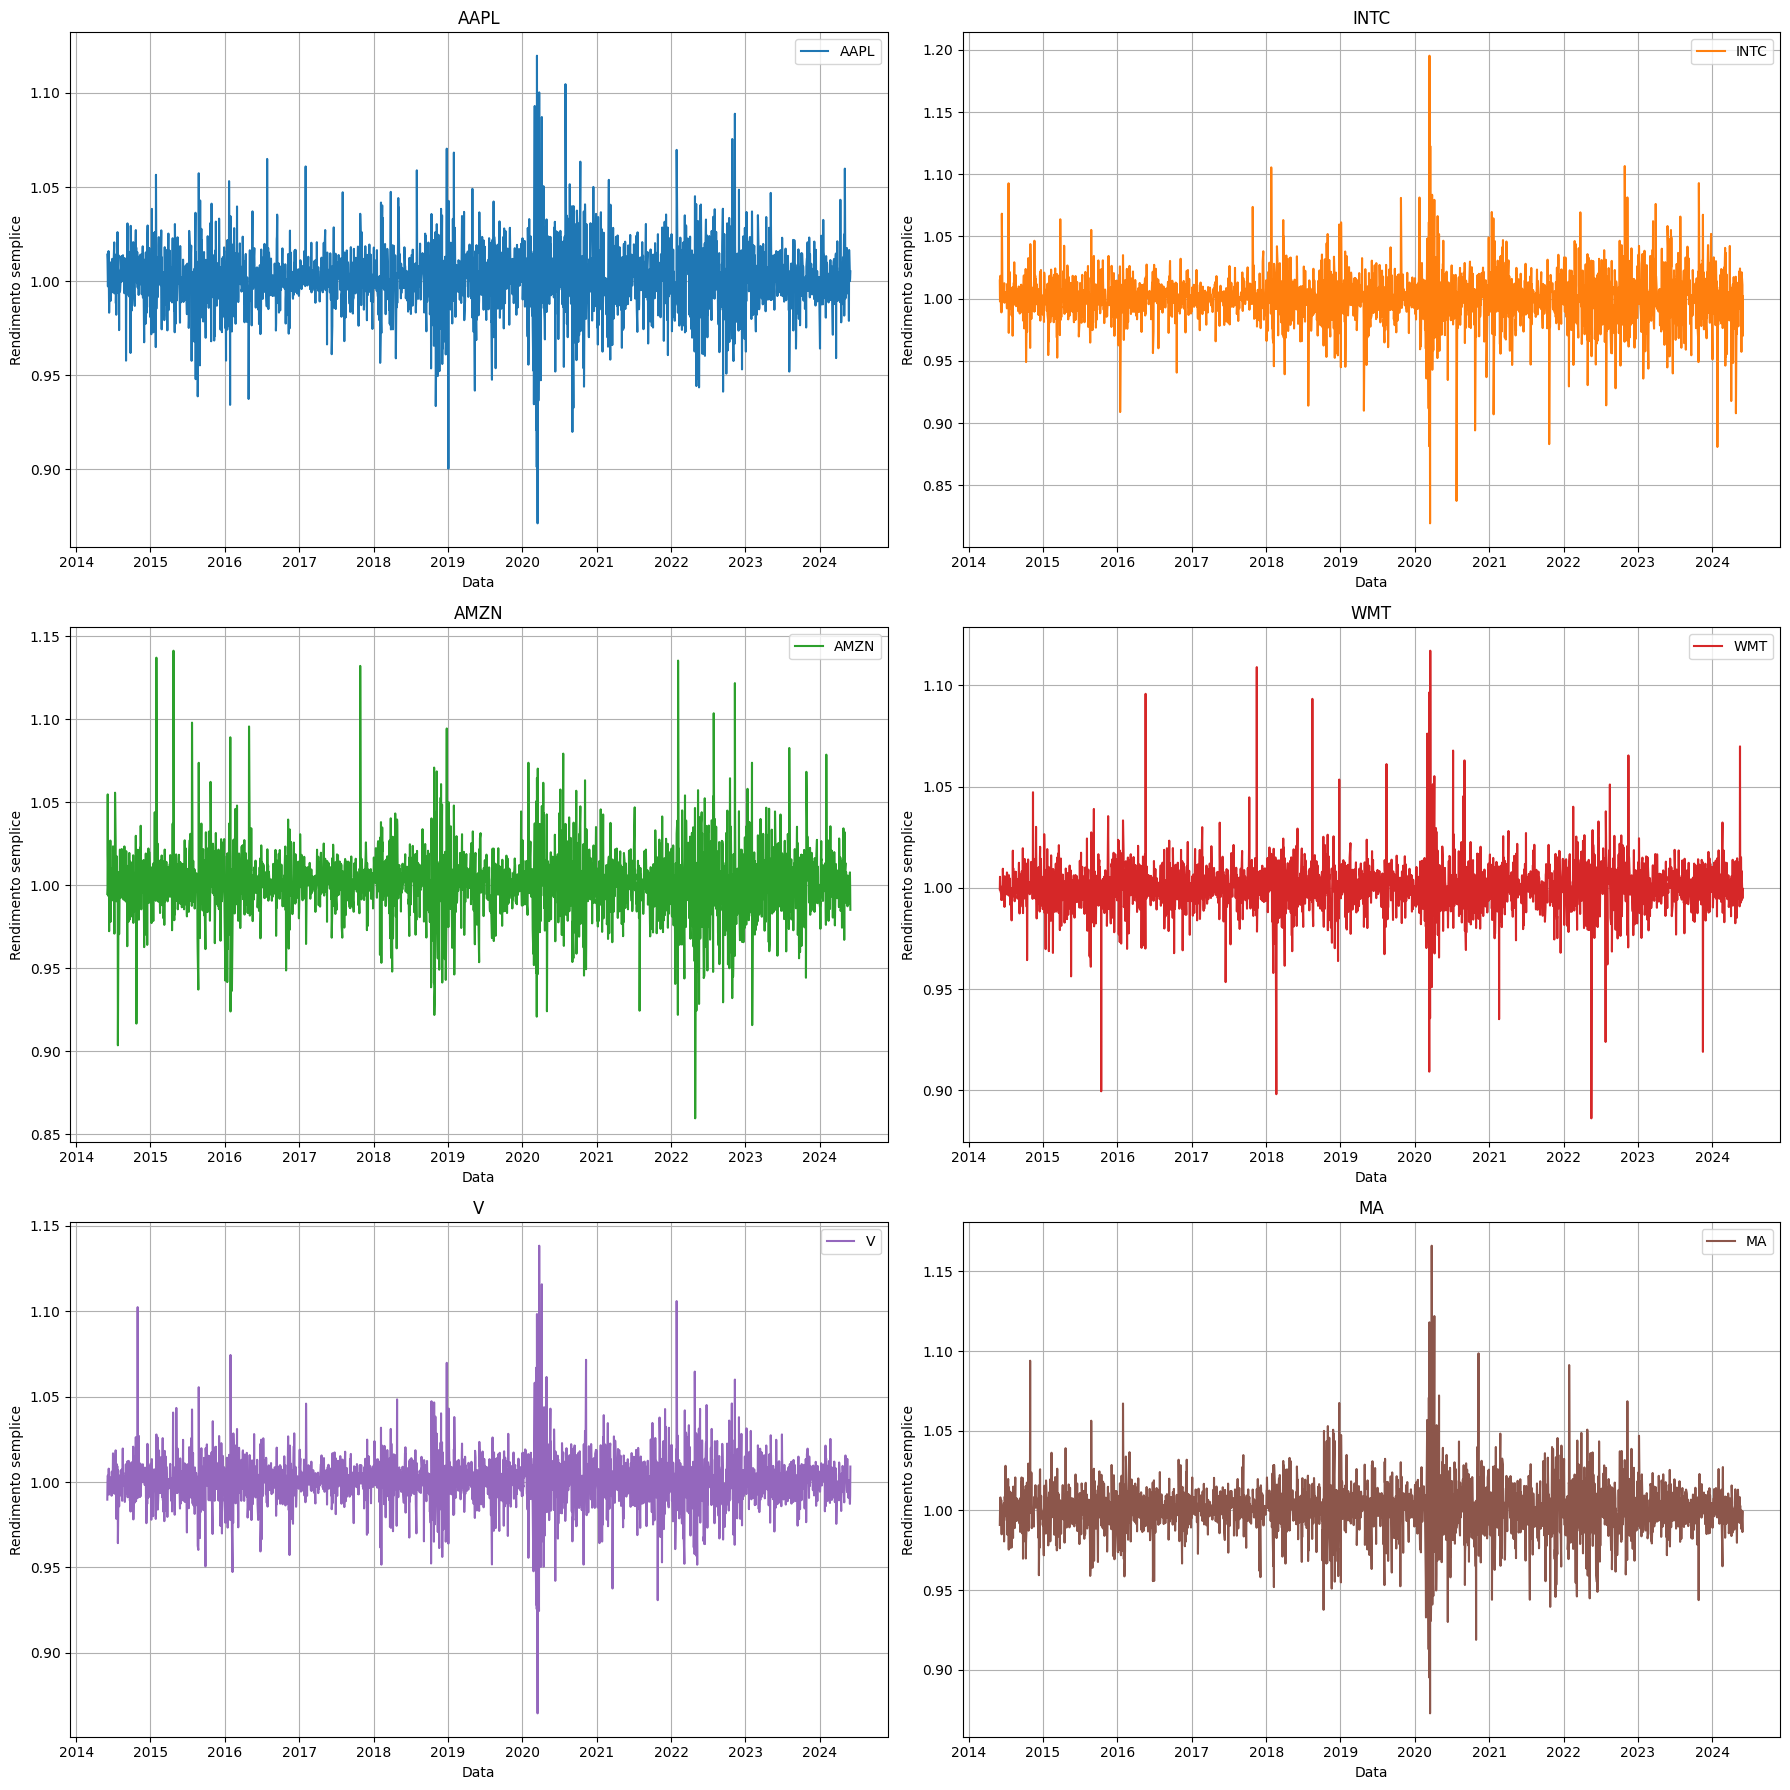

In [361]:
crea_grafici_separati(rendimenti_lordi_giornalieri, 'Rendimento semplice')

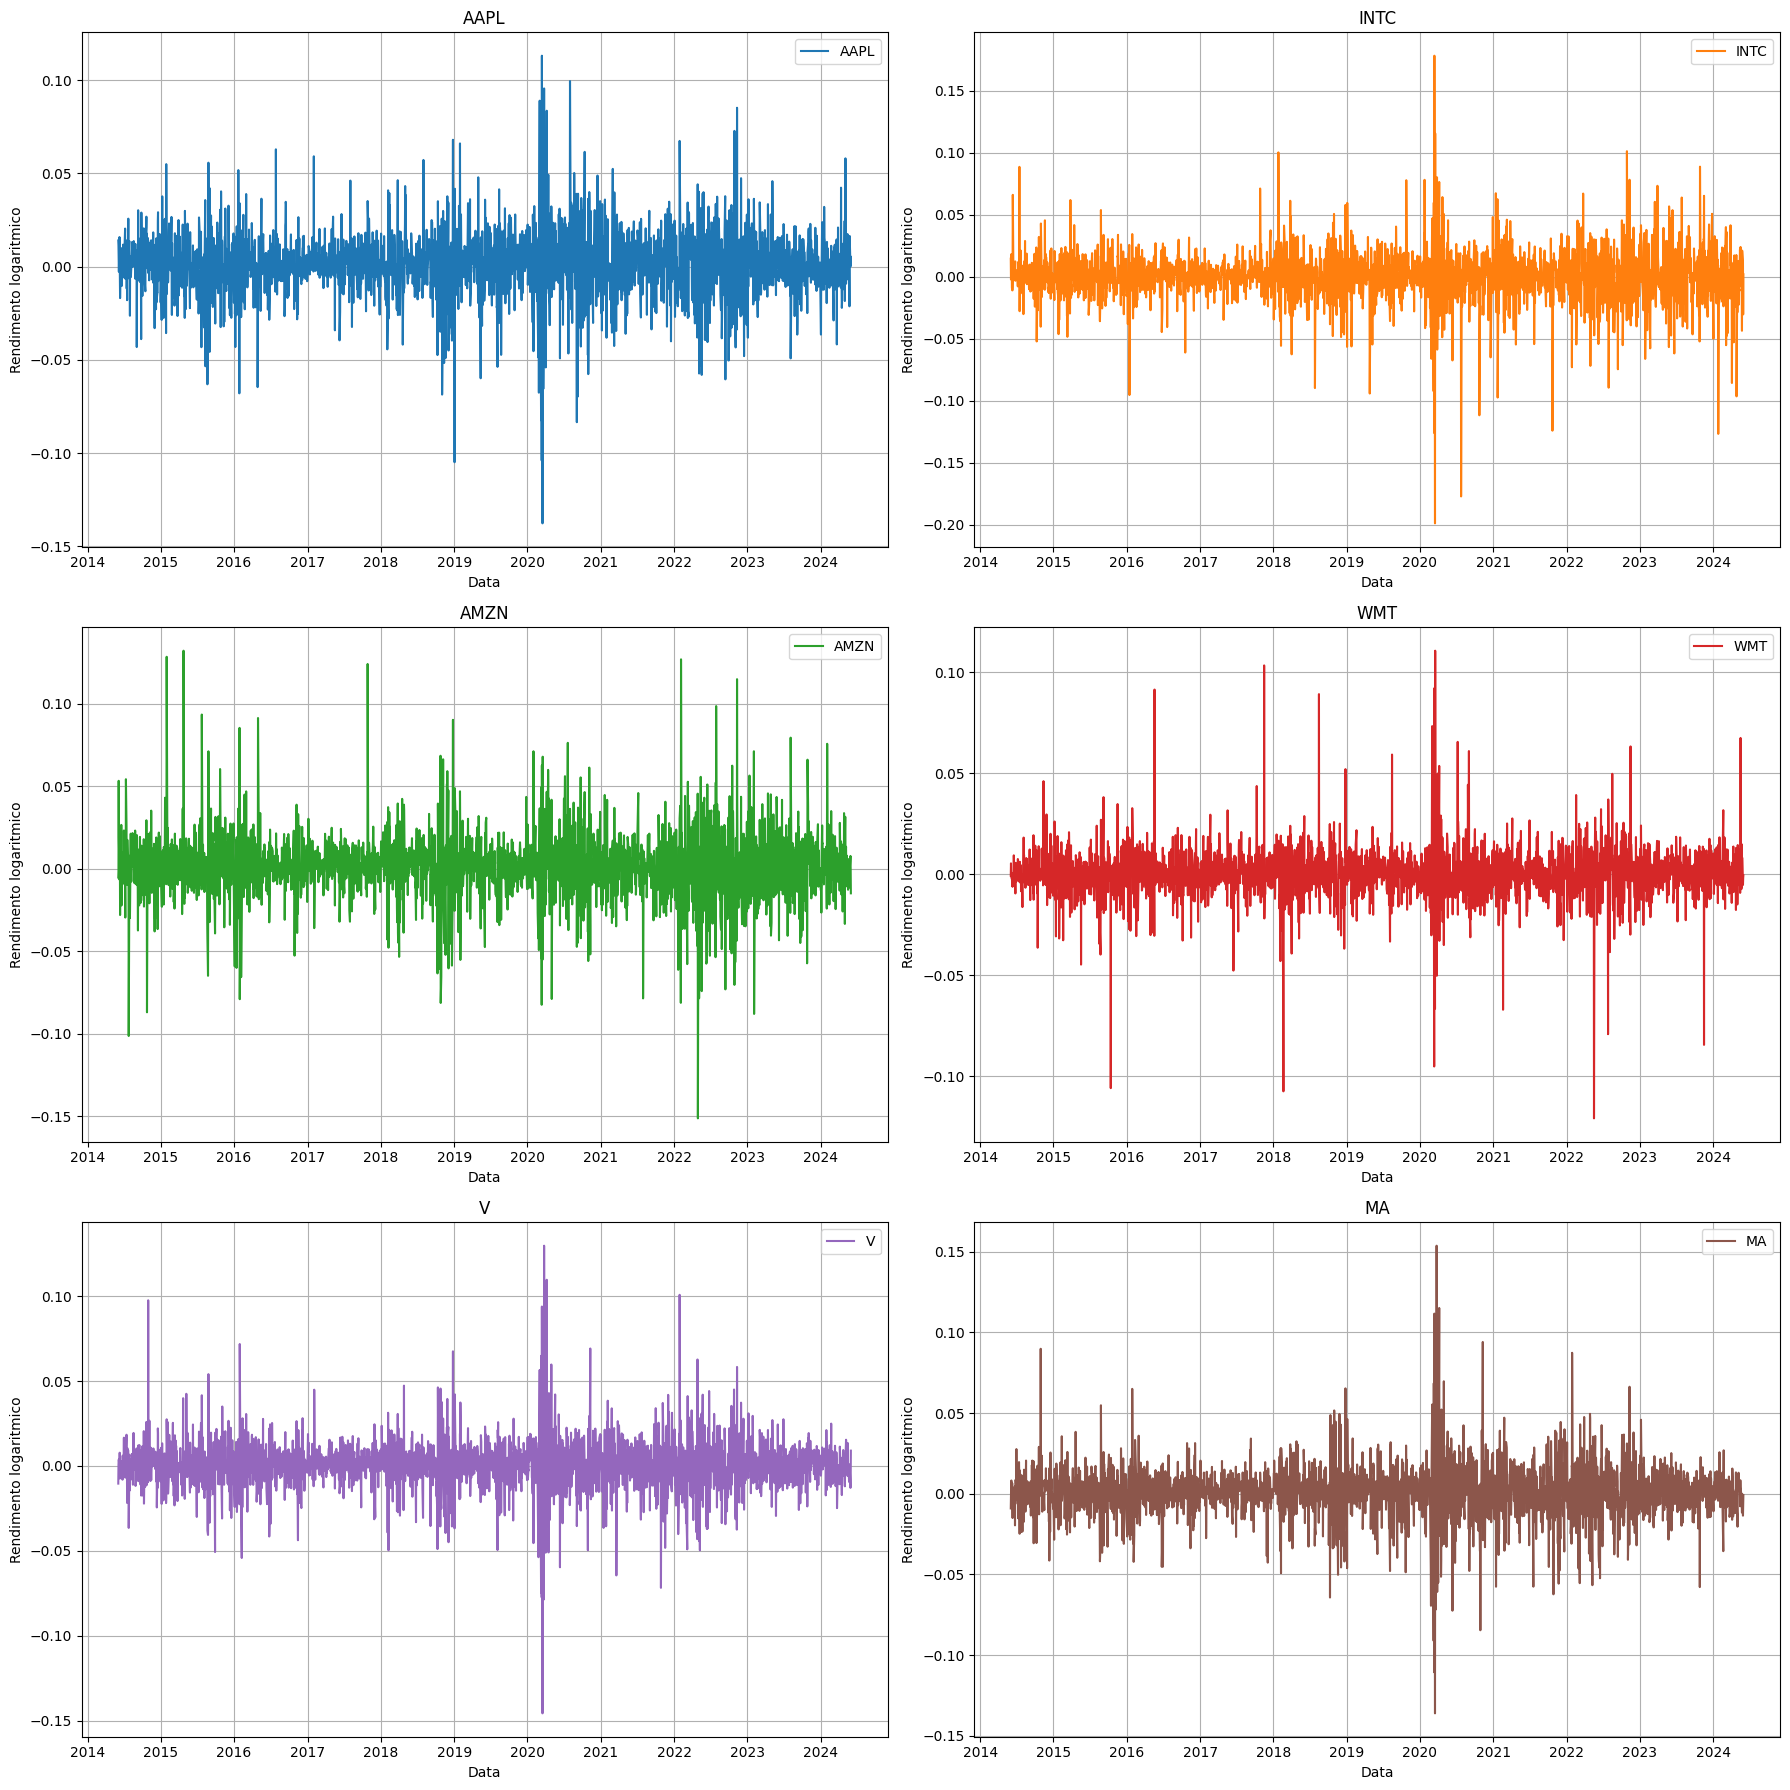

In [362]:
crea_grafici_separati(rendimenti_logaritmici, 'Rendimento logaritmico')

In [363]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512747
INTC,0.512747,1.000000


In [364]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [365]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000
